In [104]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import model_selection
from xgboost import XGBClassifier
from sklearn import metrics
from sklearn.metrics._scorer import make_scorer
from sklearn.model_selection import train_test_split
from sklearn.decomposition import TruncatedSVD
from scipy.spatial.distance import hamming

In [216]:
def calc_feature_imp(X, y, title='', plot_imp=False):
    '''
        Подсчет значимости для каждого признака из X 
    '''
    model = XGBClassifier(
            tree_method="gpu_hist",
            enable_categorical=True,
            use_label_encoder=False,
        )
    model.fit(X, y)
    
    f_importance = model.feature_importances_
    f_importance
    
    if plot_imp:
        boxplot_importance(f_importance, title)
        
    return f_importance

def boxplot_importance(features, title=''):
    '''
        Построение ящика с усами для каждого признака
        Где: features - массив значимостей для каждого признака
        title - заголовок ящика с усами
    '''
    fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
    fig.set_figheight(5)
    fig.set_figwidth(14)
    axes[0].boxplot(features)
    axes[0].grid()
    axes[0].set_title(title)
    
def plot_metric_dep_f_count(num_x, num_y, cat_x, cat_y, time_x, time_y):
    '''
        Строит графики зависимости метрики от числа признаков
        для категориальных, числовых и времянных признаков
    '''
    fig, axes = plt.subplots(1, 3, sharex=False, sharey=True)
    fig.set_figheight(5)
    fig.set_figwidth(14)
    axes[0].plot(num_x, num_y)
    axes[0].grid()
    axes[0].set_title('Значение метрики в\n зависимости от числа\nчисловых признаков')

    axes[1].plot(cat_x, cat_y)
    axes[1].grid()
    axes[1].set_title('Значение метрики в\n зависимости от числа\nкатегориальных признаков')
    
    axes[2].plot(time_x, time_y)
    axes[2].grid()
    axes[2].set_title('Значение метрики в\n зависимости от числа\nвремянных признаков')
    
    return {'countmax numeric': np.argmax(num_y) + 1,
            'countmax categorical': np.argmax(cat_y) + 1,
            'countmax time': np.argmax(time_y) + 1,
           }
    
    
    
def get_sorted_labels(labels, features_imp):
    '''
        Вернет массив меток признаков, отсортированных по убыванию значимости
        соответствующего признака
    '''
    return pd.Series(data=features_imp, index=labels).sort_values(ascending=False).index


def metrics_on_feature_count(X, y, max_count):
    '''
        Выполняет подсчет зависимости меторики от числа признаков
    '''
    metrics = np.zeros(max_count)
    for count in range(1, max_count + 1):
        model = XGBClassifier(
            tree_method="gpu_hist",
            enable_categorical=True,
            use_label_encoder=False,
        )
        X_train = X[:X.shape[0] // 2, :count]
        y_train = y[:X.shape[0] // 2]
        X_test = X[X.shape[0] // 2:, :count]
        y_test = y[X.shape[0] // 2:]
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        metrics[count - 1] = show_metrics(y_test, y_pred, get_corrcoef=True)
    return metrics
    
def show_metrics(y_true, y_pred, get_corrcoef=False):
    '''
        Если get_corrcoef = False => выполнит расчет всех метрик 
        Если get_corrcoef = True => вернет только значение MCC
    '''
    if get_corrcoef:
        return metrics.matthews_corrcoef(y_true, y_pred)
    
    data = {
        'accuracy': [metrics.accuracy_score(y_true, y_pred)],
        'matthews_corrcoef': [metrics.matthews_corrcoef(y_true, y_pred)],
        'roc_auc_score': [metrics.roc_auc_score(y_true, y_pred)],
        'precision': [metrics.precision_score(y_true, y_pred)],
        'recall': [metrics.recall_score(y_true, y_pred)],
        'f1_score': [metrics.f1_score(y_true, y_pred)]
    }
    
    return pd.DataFrame(data).round(3)


def plot_roc(y_true, y_pred, y_pred_proba):
    '''
        Сторит кривую ROC
    '''
    fp, tp, _ = metrics.roc_curve(y_true,  y_pred_proba)
    score = np.round(metrics.roc_auc_score(y_true, y_pred), 3)
    plt.plot(fp, tp, label='roc auc-оценка = ' + str(score), color='blue')
    plt.plot([0, 1], [0, 1], label='нулевая эффективность', linestyle='dashed', color='black')
    plt.xlabel("Доля ложных положительных классификаций")
    plt.ylabel("Доля верных положительных классификаций")
    plt.grid()
    plt.legend()
    plt.show()

    
def plot_pr_rec_curve(y_true, y_pred, y_pred_proba):
    '''
        Сторит кривую Precision Recall 
    '''
    precision, recall, _ = metrics.precision_recall_curve(y_true,  y_pred_proba)
    score = np.round(metrics.auc(x=recall, y=precision), 3)
    plt.plot(recall, precision, label='площадь под графиком = ' + str(score), color='blue')
    plt.plot([0, 1], [0, 0], label='нулевая эффективность', linestyle='dashed', color='black')
    plt.xlabel("recall")
    plt.ylabel("precision")
    plt.grid()
    plt.legend()
    plt.show()
    

    

def fit_and_find_hpar(model, param_dis, X, y, n_splits=10, test_size=0.3):
    '''
        Выполняет подбор гиперпараметров
    '''
    np.random.seed=334
    split_strategy = model_selection.StratifiedShuffleSplit(n_splits=n_splits, test_size=test_size)
    
     
    search_model = RandomizedSearchCV(estimator=model, 
                            param_distributions=param_dis, 
                            scoring=make_scorer(metrics.matthews_corrcoef), 
                            cv=split_strategy,
                            )
    
    search_model.fit(X, y)
    return search_model

# Описание предметной области 
Во время производственного процесса деталь проходит через разные этапы изготовления, на каждом из которых измеряются определенные характеристики детали. В результате прохождения детали через производственный процесс специальный сотрудник выполняет контроль качества детали (по данным характеристикам) и определяет является ли деталь бракованной, или нет. Детали присваивается id и ее характеристики записываются в виде строки в таблицу. Каждый столбец соответствует своей характеристике данной детали (каждая строка соответствует своей детали). В самом последнем столбце указывается единица, если деталь не прошла контроль качества, и ноль, если контроль качества пройден. Подобным образом формируется таблица, которая является источником данных для будущей модели и называется **датасетом**.

Каждую измеренную характеристику (соответствующую столбцу) будем называть **признаком**, саму деталь **объектом**, а ее результат прохождения контроля качества – **меткой** (последний столбец таблицы) или **таргетом**.

**Цель данного проекта** - построение и тестирование модели для предсказания прохождения деталью контроля качества.

Датасет включает в себя три таблицы в формате csv: train_numeric, train_categorical, train_date (для чилсовых, категориальных, временных признаков соответственно)

# Исследование данных

Выполним чтение таблиц с числовыми и категориальными признаками

In [106]:

df_num = pd.read_csv('datasets/train_numeric.csv', sep=',', nrows=200000, dtype='float64')
df_cat = pd.read_csv('datasets/train_categorical.csv', sep=',', nrows=200000, dtype='category')
df_num.shape

(200000, 970)

In [107]:
df_cat.shape

(200000, 2141)

In [108]:
df_num.head()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,4.0,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,7.0,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,9.0,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,11.0,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


In [109]:
df_cat.head()

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Видно, что в исходных данных присутствует большое количество пропусков. Также мы имеем дело с крайне большим количеством признаков (общее число столбцов больше трех тысяч).

Вызовем метод describe для таблицы с числовыми данными. Он выведет следующие статистические величины для каждого столбца: count – количество значений (не включая пропуски); mean – среднее арифметическое; std – стандартное отклонение; min, max – минимальное и максимальное значение выборки; числа со знаком % - квартили (значения признака, которые делят упорядоченное множество элементов столбца на 4 равные части).

In [110]:
df_num.describe()

,Id,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
count,200000.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,...,5316.000000,5316.000000,5316.000000,5316.000000,5316.000000,10383.000000,10383.000000,10383.000000,10383.000000,200000.000000
mean,200029.947135,-0.001997,-0.002514,-0.000876,-0.000985,0.000722,0.003152,0.000258,0.001459,-0.001297,...,-0.000002,0.000015,0.000478,0.000155,0.000188,-0.000008,0.000201,0.000370,0.000049,0.005645
std,115402.589920,0.080453,0.093157,0.210657,0.210733,0.093107,0.162213,0.019291,0.103561,0.115565,...,0.000045,0.000397,0.018767,0.001966,0.250023,0.000091,0.013882,0.010551,0.000922,0.074921
min,4.000000,-0.565000,-0.474000,-0.397000,-0.416000,-0.404000,-0.612000,-0.052000,-0.232000,-0.408000,...,-0.001000,0.000000,0.000000,0.000000,-0.250000,-0.001000,0.000000,0.000000,0.000000,0.000000
25%,100148.500000,-0.055000,-0.064000,-0.179000,-0.179000,-0.056000,-0.066000,-0.015000,-0.072000,-0.082000,...,0.000000,0.000000,0.000000,0.000000,-0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,200353.000000,0.003000,0.004000,-0.033000,-0.034000,0.031000,0.070000,0.000000,-0.032000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,299819.500000,0.056000,0.063000,0.294000,0.294000,0.074000,0.116000,0.015000,0.088000,0.076000,...,0.000000,0.000000,0.000000,0.000000,0.250000,0.000000,0.000000,0.000000,0.000000,0.000000
max,399899.000000,0.278000,0.280000,0.567000,0.566000,0.422000,0.388000,0.422000,0.528000,0.500000,...,0.001000,0.021000,1.000000,0.057000,0.250000,0.001000,1.000000,0.509000,0.046000,1.000000


Невооруженным глазом можно заметить что количество объектов (поле id строки count) в среднем почти в 2 раза (иногда и в 4 раза) больше количества непропущенных значений в каждом из столбцов датафрейма. Получается, что основную часть входных данных составляют пропуски. В такой ситуации мы не можем просто взять и удалить строки с пропусками, так как это приведет к потере основной части данных.

Вспомним, что каждый объект таблицы соответствует своей метке. В данном случае число возможных меток – 2: либо деталь прошла контроль качества (метка = 0), либо – нет (метка = 1). Посчитаем количество объектов в каждом из классов и сравним полученные значения между собой.

In [111]:
count_targets = df_num.groupby(by='Response')['Id'].count()
count_targets

Response
0.0    198871
1.0      1129
Name: Id, dtype: int64

Количество объектов не одинаково в обоих классах. Более того, Число объектов нулевого класса превосходит число объектов единичного почти в 175 раз. Подобные выборки (когда количество объектов в классах различается сильно) называются несбалансированными.

## Нахождение значимых категориальных признаков 

In [112]:
df_cat

,Id,L0_S1_F25,L0_S1_F27,L0_S1_F29,L0_S1_F31,L0_S2_F33,L0_S2_F35,L0_S2_F37,L0_S2_F39,L0_S2_F41,...,L3_S49_F4225,L3_S49_F4227,L3_S49_F4229,L3_S49_F4230,L3_S49_F4232,L3_S49_F4234,L3_S49_F4235,L3_S49_F4237,L3_S49_F4239,L3_S49_F4240
0,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,399894,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199996,399896,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199997,399897,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199998,399898,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Особенно большое количество признаков встречается в таблице с категориальными данными – 2141 признак.

In [113]:
df_cat.drop('Id', inplace=True, axis=1)
df_num.drop('Id', inplace=True, axis=1)

In [114]:
df_cat.columns

Index(['L0_S1_F25', 'L0_S1_F27', 'L0_S1_F29', 'L0_S1_F31', 'L0_S2_F33',
       'L0_S2_F35', 'L0_S2_F37', 'L0_S2_F39', 'L0_S2_F41', 'L0_S2_F43',
       ...
       'L3_S49_F4225', 'L3_S49_F4227', 'L3_S49_F4229', 'L3_S49_F4230',
       'L3_S49_F4232', 'L3_S49_F4234', 'L3_S49_F4235', 'L3_S49_F4237',
       'L3_S49_F4239', 'L3_S49_F4240'],
      dtype='object', length=2140)

Для каждого столбца оценим долю непропущенных элементов – объект freq.

In [115]:
freq = pd.DataFrame((df_cat.count(axis=0) / df_cat.shape[0]), columns=['segment'])
freq

,segment
L0_S1_F25,0.000040
L0_S1_F27,0.000040
L0_S1_F29,0.000040
L0_S1_F31,0.000040
L0_S2_F33,0.000195
...,...
L3_S49_F4234,0.000020
L3_S49_F4235,0.000035
L3_S49_F4237,0.000035
L3_S49_F4239,0.000020


Построим «ящик с усами» по этим данным.

<AxesSubplot:ylabel='доли непропущенных элементов для каждого столбца'>

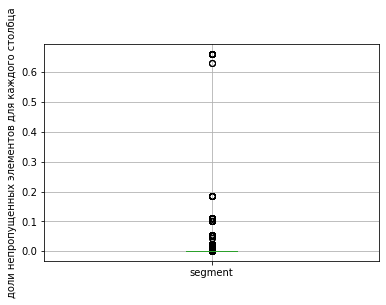

In [116]:
plt.ylabel('доли непропущенных элементов для каждого столбца')
freq.boxplot(column='segment')

Как видно основная часть категориальных столбцов датасета практически полностью состоит из пропущенных ячеек – доля непропущенных значений в них меньше 0.2 (поэтому ящик сильно «сплющен» возле нулевого значения). Исходя из этого можно сделать предположение, что данные столбцы не оказывают существенного влияния на целевую переменную и их можно не учитывать. Установим порог для долей непропущенных элементов равный 0.60. Выведем названия признаков, удовлетворяющих порогу.

In [117]:
important_features = freq['segment'][freq['segment'] > 0.60].index
important_features

Index(['L3_S29_F3317', 'L3_S29_F3320', 'L3_S29_F3323', 'L3_S29_F3326',
       'L3_S29_F3329', 'L3_S29_F3332', 'L3_S29_F3335', 'L3_S29_F3338',
       'L3_S29_F3341', 'L3_S29_F3344', 'L3_S29_F3347', 'L3_S29_F3350',
       'L3_S29_F3353', 'L3_S29_F3356', 'L3_S29_F3359', 'L3_S29_F3362',
       'L3_S29_F3364', 'L3_S29_F3366', 'L3_S29_F3369', 'L3_S29_F3372',
       'L3_S29_F3375', 'L3_S29_F3378', 'L3_S29_F3381', 'L3_S29_F3384',
       'L3_S29_F3387', 'L3_S29_F3390', 'L3_S29_F3392', 'L3_S29_F3394',
       'L3_S29_F3397', 'L3_S29_F3400', 'L3_S29_F3403', 'L3_S29_F3406',
       'L3_S29_F3409', 'L3_S29_F3411', 'L3_S29_F3414', 'L3_S29_F3416',
       'L3_S29_F3418', 'L3_S29_F3420', 'L3_S29_F3423', 'L3_S29_F3426',
       'L3_S29_F3429', 'L3_S29_F3432', 'L3_S29_F3435', 'L3_S29_F3438',
       'L3_S29_F3441', 'L3_S29_F3444', 'L3_S29_F3446', 'L3_S29_F3448',
       'L3_S29_F3451', 'L3_S29_F3454', 'L3_S29_F3457', 'L3_S29_F3460',
       'L3_S29_F3463', 'L3_S29_F3466', 'L3_S29_F3469', 'L3_S29_F3472',
      

In [118]:
important_features.shape

(63,)

In [119]:
df_cat[important_features].agg(axis=0, func=pd.Series.unique)

,L3_S29_F3317,L3_S29_F3320,L3_S29_F3323,L3_S29_F3326,L3_S29_F3329,L3_S29_F3332,L3_S29_F3335,L3_S29_F3338,L3_S29_F3341,L3_S29_F3344,...,L3_S29_F3466,L3_S29_F3469,L3_S29_F3472,L3_S29_F3475,L3_S29_F3478,L3_S29_F3481,L3_S29_F3484,L3_S29_F3487,L3_S29_F3490,L3_S29_F3493
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1,...,T1,T1,T1,T1,T1,T1,T1,T1,T1,T1


## Кодирование категориальных признаков

Значения категориальных переменных показывают принадлежность объекта к какой-либо группе, классу, а не величину, множество значений которой лежит на какой-либо числовой оси. Если не учесть эту особенность, то при построении модели алгоритм просто примет эти признаки за порядковые, что может повлиять на точность предсказаний.
Наиболее распространенным способом перевода категориальных признаков в порядковые (без потери исходного смысла) является алгоритм  быстрого кодирования (One-Hot encoding). Его суть достаточно простая: категориальный столбец разбивается на n столбцов (n - количество категорий для данного признака). Каждый столбец соответствует своей категории. Для каждого объекта выборки выполняются следующие действия: в колонку относящуюся к категории объекта ставится единица, во все остальные – ноль. Например: у нас есть признак «цвет». Он может быть: белым, синим и красным, тогда для четырех объектов кодирование будет следующим.

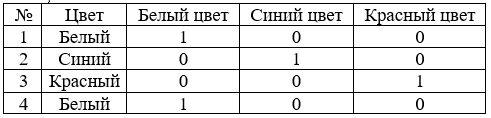

Аналогичным образом закодируем категориальные признаки из нашего датасета. Получим матрицу X_categorical

In [120]:

one_hot_encoder = OneHotEncoder()
X_categorical = one_hot_encoder.fit_transform(df_cat[important_features].to_numpy())
print(X_categorical.shape)
X_categorical = X_categorical.toarray()
X_categorical

(200000, 126)


array([[0., 1., 0., ..., 1., 0., 1.],
       [0., 1., 0., ..., 1., 0., 1.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [0., 1., 0., ..., 1., 0., 1.]])

In [121]:
y = df_num['Response'].to_numpy()
y

array([0., 0., 0., ..., 0., 0., 0.])

Для класса 0 найдем его "типичный объект". Для этого, для каждого столбца объектов этого класса определим значения, встречающиеся чаще всего. Эти знаяения и будут формировать признаки полученного объекта.

In [122]:
base_for_zero = np.round(X_categorical[y == 0].sum(axis=0) / X_categorical.shape[0])
base_for_zero

array([1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0.,
       1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1.,
       0., 1., 0., 1., 0., 1., 0.])

Далее для каждого объекта в выборке вычислим расстояние Хемминга до "типчного объекта класса 0"

In [123]:
hamming_feature = np.apply_along_axis(lambda x: hamming(x, base_for_zero), axis=1, arr=X_categorical)
hamming_feature

array([1., 1., 0., ..., 0., 0., 1.])

Добавим новый признак в исходную матрицу

In [124]:
X_categorical = np.concatenate((X_categorical, hamming_feature[...,np.newaxis]), axis=1)
X_categorical

array([[0., 1., 0., ..., 0., 1., 1.],
       [0., 1., 0., ..., 0., 1., 1.],
       [1., 0., 1., ..., 1., 0., 0.],
       ...,
       [1., 0., 1., ..., 1., 0., 0.],
       [1., 0., 1., ..., 1., 0., 0.],
       [0., 1., 0., ..., 0., 1., 1.]])

## Отбор числовых и категориальных признаков

In [125]:
df_num

,L0_S0_F0,L0_S0_F2,L0_S0_F4,L0_S0_F6,L0_S0_F8,L0_S0_F10,L0_S0_F12,L0_S0_F14,L0_S0_F16,L0_S0_F18,...,L3_S50_F4245,L3_S50_F4247,L3_S50_F4249,L3_S50_F4251,L3_S50_F4253,L3_S51_F4256,L3_S51_F4258,L3_S51_F4260,L3_S51_F4262,Response
0,0.030,-0.034,-0.197,-0.179,0.118,0.116,-0.015,-0.032,0.020,0.083,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,0.088,0.086,0.003,-0.052,0.161,0.025,-0.015,-0.072,-0.225,-0.147,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
3,-0.036,-0.064,0.294,0.330,0.074,0.161,0.022,0.128,-0.026,-0.046,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
4,-0.055,-0.086,0.294,0.330,0.118,0.025,0.030,0.168,-0.169,-0.099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,-0.25,0.0,0.0,0.0,0.0,0.0
199996,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
199997,0.036,0.056,0.330,0.330,-0.056,0.116,0.015,0.048,-0.010,-0.099,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
199998,-0.055,-0.056,-0.179,-0.161,-0.056,0.070,0.000,0.008,-0.026,0.013,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0


Извлечем порядковые (числовые) признаки (столбцы) из датафрейма df_num в массив numpy - X_numeric. 

In [126]:
X_numeric = df_num.drop(columns='Response').to_numpy()
X_numeric

array([[ 0.03 , -0.034, -0.197, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan],
       [ 0.088,  0.086,  0.003, ...,    nan,    nan,    nan],
       ...,
       [ 0.036,  0.056,  0.33 , ...,    nan,    nan,    nan],
       [-0.055, -0.056, -0.179, ...,    nan,    nan,    nan],
       [   nan,    nan,    nan, ...,    nan,    nan,    nan]])

In [127]:
X_numeric.shape

(200000, 968)

Теперь объединим полученные матрицы X_numeric и X_categorical в одну матрицу признаков X. Просто разместим столбцы матриц рядом друг с другом.

In [128]:
X = np.concatenate((X_numeric, X_categorical), axis=1)
X

array([[ 0.03 , -0.034, -0.197, ...,  0.   ,  1.   ,  1.   ],
       [   nan,    nan,    nan, ...,  0.   ,  1.   ,  1.   ],
       [ 0.088,  0.086,  0.003, ...,  1.   ,  0.   ,  0.   ],
       ...,
       [ 0.036,  0.056,  0.33 , ...,  1.   ,  0.   ,  0.   ],
       [-0.055, -0.056, -0.179, ...,  1.   ,  0.   ,  0.   ],
       [   nan,    nan,    nan, ...,  0.   ,  1.   ,  1.   ]])

Есть множество способов оценить значимость признака. В данной работе мы будем использовать алгоритм градиентного бустинга из библиотеки xgboost. Обучим модель. При этом для нас несильно важно качество предсказаний полученной модели, так как мы используем ее только для отбора наиболее значимых признаков.  Подробнее этот алгоритм рассмотрен в следующих разделах.

In [129]:

model = XGBClassifier(
            tree_method="gpu_hist",
            enable_categorical=True,
            use_label_encoder=False,
        )


model.fit(X, y)
f_importance = model.feature_importances_
f_importance

[00:55:51] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


array([0.00371853, 0.0025491 , 0.00308008, ..., 0.        , 0.        ,
       0.        ], dtype=float32)

У градиентного бустинга есть замечательное свойство – он способен определять важность признаков. Это возможно благодаря алгоритму MDI (mean decrease in impurity), который вычисляет важность объекта на основе усредненного значения доли объектов, которые он разделил на первом уровне каждого решающего дерева.

Полученные оценки разобьем на два массива: один соответствует категориальными признакам (categorical_f) другой порядковым (numeric_f). Далее для каждого массива построим «ящики с усами».

In [130]:
numeric_f = f_importance[:968]
categorical_f = f_importance[968:]

Text(0.5, 1.0, 'Разброс категориальных признаков по релевантности')

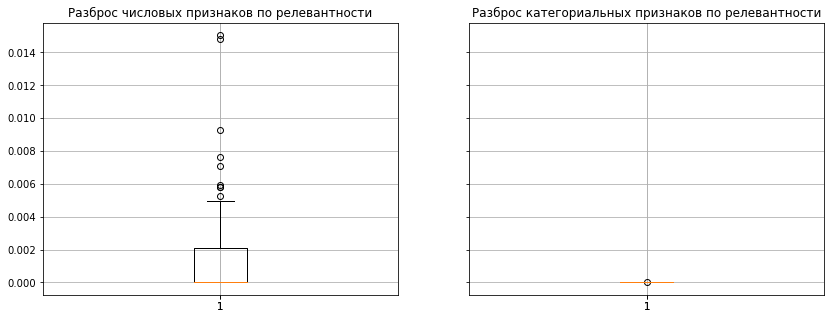

In [131]:

fig, axes = plt.subplots(1, 2, sharex=True, sharey=True)
fig.set_figheight(5)
fig.set_figwidth(14)
axes[0].boxplot(numeric_f)
axes[0].grid()
axes[0].set_title('Разброс числовых признаков по релевантности')

axes[1].boxplot(categorical_f)
axes[1].grid()
axes[1].set_title('Разброс категориальных признаков по релевантности')
#plt.title('Разброс признаков по релевантности')

Видно, что числовые признаки можно условно разделить на две части: те что лежат ниже значения 0.005 (эти признаки мы будем считать незначимыми) и те которые лежат выше 0.005 (их мы будем считать значимыми). Если сравнить порядковые признаки с категориальными, то последние лежат во много раз ниже выбранного нами порога в 0.005. Поэтому при построении модели категориальные признаки использоваться не будут, как минимум – при построении моделей основанных на решающих деревьях.

Применим порог 0.005 для отделения значимых признаков и по их индексам определим названия столбцов в датафрейме. Получим 9 наиболее значимых признаков и поместим их названия в chosen_features. По этим признакам будет строится модель.

In [132]:
m_features = numeric_f.argsort()[::-1][:9]
m_features

array([849, 862, 848, 360, 866, 164, 937, 105,  73], dtype=int64)

In [133]:
numeric_f[m_features]

array([0.01503585, 0.01482963, 0.00930516, 0.00766288, 0.00709718,
       0.00593049, 0.00581373, 0.0057841 , 0.00528963], dtype=float32)

## Работа с времянными признаками
Теперь изучим таблицу с временными данными

In [134]:
df_dat = pd.read_csv('datasets/train_date.csv', sep=',', nrows=200000, dtype='float64')
df_dat

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
0,4.0,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,82.24,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,7.0,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,1618.70,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,9.0,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,1149.20,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,11.0,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,602.64,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,399894.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,724.88,724.88,724.88,724.88,724.88,724.89,724.89,724.89,724.89,724.89
199996,399896.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199997,399897.0,675.79,675.79,675.79,675.79,675.79,675.79,675.79,675.79,675.79,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
199998,399898.0,1225.57,1225.57,1225.57,1225.57,1225.57,1225.57,1225.57,1225.57,1225.57,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [135]:
df_dat.describe()

,Id,L0_S0_D1,L0_S0_D3,L0_S0_D5,L0_S0_D7,L0_S0_D9,L0_S0_D11,L0_S0_D13,L0_S0_D15,L0_S0_D17,...,L3_S50_D4246,L3_S50_D4248,L3_S50_D4250,L3_S50_D4252,L3_S50_D4254,L3_S51_D4255,L3_S51_D4257,L3_S51_D4259,L3_S51_D4261,L3_S51_D4263
count,200000.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,115932.000000,...,5316.000000,5316.000000,5316.000000,5316.000000,5316.000000,10383.000000,10383.000000,10383.000000,10383.000000,10383.000000
mean,200029.947135,872.728727,872.728727,872.728727,872.728727,872.728727,872.728727,872.728727,872.728727,872.728727,...,1026.901055,1026.901055,1026.901055,1026.901055,1026.901055,1029.697533,1029.697533,1029.697533,1029.697533,1029.697533
std,115402.589920,503.473668,503.473668,503.473668,503.473668,503.473668,503.473668,503.473668,503.473668,503.473668,...,427.886773,427.886773,427.886773,427.886773,427.886773,430.562826,430.562826,430.562826,430.562826,430.562826
min,4.000000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,0.010000,...,1.320000,1.320000,1.320000,1.320000,1.320000,1.380000,1.380000,1.380000,1.380000,1.380000
25%,100148.500000,392.410000,392.410000,392.410000,392.410000,392.410000,392.410000,392.410000,392.410000,392.410000,...,558.090000,558.090000,558.090000,558.090000,558.090000,558.060000,558.060000,558.060000,558.060000,558.060000
50%,200353.000000,904.010000,904.010000,904.010000,904.010000,904.010000,904.010000,904.010000,904.010000,904.010000,...,1225.210000,1225.210000,1225.210000,1225.210000,1225.210000,1225.290000,1225.290000,1225.290000,1225.290000,1225.290000
75%,299819.500000,1364.270000,1364.270000,1364.270000,1364.270000,1364.270000,1364.270000,1364.270000,1364.270000,1364.270000,...,1408.320000,1408.320000,1408.320000,1408.320000,1408.320000,1408.500000,1408.500000,1408.500000,1408.500000,1408.500000
max,399899.000000,1713.710000,1713.710000,1713.710000,1713.710000,1713.710000,1713.710000,1713.710000,1713.710000,1713.710000,...,1457.500000,1457.500000,1457.500000,1457.500000,1457.500000,1457.500000,1457.500000,1457.500000,1457.500000,1457.500000


Подсчитаем количество ячеек без пропусков для каждого столбца. Мы также удалим столбец Id (через метод drop), после этого обновим индексы методом reset_index. При этом исходные индексы просто перенесутся в новый соседний столбец index, вычисленные до этого значения частот останутся в столбце 0. 

In [136]:
count_not_null = df_dat.count(axis=0).drop('Id')
count_not_null

L0_S0_D1        115932
L0_S0_D3        115932
L0_S0_D5        115932
L0_S0_D7        115932
L0_S0_D9        115932
                 ...  
L3_S51_D4255     10383
L3_S51_D4257     10383
L3_S51_D4259     10383
L3_S51_D4261     10383
L3_S51_D4263     10383
Length: 1156, dtype: int64

In [137]:
count_not_null = count_not_null.reset_index()
count_not_null

,index,0
0,L0_S0_D1,115932
1,L0_S0_D3,115932
2,L0_S0_D5,115932
3,L0_S0_D7,115932
4,L0_S0_D9,115932
...,...,...
1151,L3_S51_D4255,10383
1152,L3_S51_D4257,10383
1153,L3_S51_D4259,10383
1154,L3_S51_D4261,10383


Изменим названия колонок (столбец index). Оставим только название станций, на которых происходили измерения (исходную колонку просто перенесем в столбец feature). После этого удалим дубликаты названий методом drop_dublicates.

In [138]:
count_not_null.sort_values(by=0, inplace=True, ascending=False)
count_not_null['feature'] = count_not_null['index']
count_not_null['index'] = count_not_null['index'].str.split('_', expand=True)[1]
count_not_null

,index,0,feature
1054,S37,188967,L3_S37_D3949
1053,S37,188967,L3_S37_D3947
1052,S37,188967,L3_S37_D3945
1051,S37,188967,L3_S37_D3943
1050,S37,188967,L3_S37_D3942
...,...,...,...
1096,S42,1,L3_S42_D4057
1094,S42,1,L3_S42_D4049
1095,S42,1,L3_S42_D4053
1118,S46,0,L3_S46_D4135


In [139]:
count_not_null.drop_duplicates('index', inplace=True)
count_not_null

,index,0,feature
1054,S37,188967,L3_S37_D3949
1003,S30,188856,L3_S30_D3781
906,S29,188815,L3_S29_D3383
1033,S34,188009,L3_S34_D3883
1020,S33,187953,L3_S33_D3858
12,S1,115960,L0_S1_D26
49,S8,115937,L0_S8_D150
1,S0,115932,L0_S0_D3
1044,S36,96117,L3_S36_D3923
1039,S35,92968,L3_S35_D3905


Примем названия станций за индексы.

In [140]:
count_not_null.shape

(52, 3)

In [141]:
count_not_null = count_not_null.set_index('index')
count_not_null

,0,feature
index,,
S37,188967,L3_S37_D3949
S30,188856,L3_S30_D3781
S29,188815,L3_S29_D3383
S34,188009,L3_S34_D3883
S33,187953,L3_S33_D3858
S1,115960,L0_S1_D26
S8,115937,L0_S8_D150
S0,115932,L0_S0_D3
S36,96117,L3_S36_D3923


Данный участок кода выполняет кодирование для каждого объекта по новым признакам: если в ячейке стоит единица, значит объект проходил через данную станцию. Ноль говорит о том, что объекта не было на данной станции S, либо данные об этом потеряны. Параллельно с этим вычисляются признаки start_st и end_st, которые соответствуют номерам начальной и конечной станции.

In [142]:
new_features = None
new_cols = sorted(count_not_null.index.to_list(), reverse=False)
last_cols =  count_not_null['feature'].to_list()
for chunk in pd.read_csv('datasets/train_date.csv', usecols=['Id'] + last_cols, chunksize=60000, low_memory=False, nrows=200000):
    chunk.columns = ['Id'] + new_cols
    chunk['start_st'] = -1
    chunk['end_st'] = -1
    for station in new_cols:
        full_col = station
        chunk[station] = 1 * (chunk[full_col].astype('float64') >= 0)
        chunk.loc[(chunk['start_st'] == -1) & (chunk['Id'].isin(chunk[chunk[station] > 0].Id)), 'start_st'] = int(station[1:])
        chunk.loc[(chunk['Id'].isin(chunk[chunk[station] > 0].Id)), 'end_st'] = int(station[1:])
    new_features = pd.concat([new_features, chunk])
    del chunk
new_features

,Id,S0,S1,S10,S11,S12,S13,S14,S15,S16,...,S49,S5,S50,S51,S6,S7,S8,S9,start_st,end_st
0,4,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,42
1,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,42
2,7,1,1,1,0,0,1,1,0,1,...,0,0,0,0,0,0,0,0,0,42
3,9,1,1,1,0,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,42
4,11,1,1,0,1,1,0,0,1,1,...,0,0,0,0,0,0,0,0,0,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,399894,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,0,1,1,31,9
199996,399896,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,30,42
199997,399897,1,1,1,0,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,42
199998,399898,1,1,0,1,1,0,1,0,1,...,0,0,0,0,0,0,0,0,0,42


В следующем блоке происходят аналогичные вещи – формируются новые признаки, которые в будущем могут улучшить качество работы модели: mindate, maxdate – минимальное и максимальное значение времени для данного объекта (del_t – разница между этими значениями), min_time_st – номер станции соответствующий mindate, max_time_st – тоже самое но относится к maxdate.

In [143]:
minmaxfeatures = None
for chunk in pd.read_csv('datasets/train_date.csv', usecols=['Id'] + last_cols, chunksize=60000, low_memory=False):
    l_cols = chunk.columns.drop('Id').values
    df_chunk = chunk[['Id']].copy()
    df_chunk['mindate'] = chunk[l_cols].min(axis=1).values
    df_chunk['maxdate'] = chunk[l_cols].max(axis=1).values
    df_chunk['min_time_st'] =  chunk[l_cols].idxmin(axis = 1).apply(lambda s: int(s.split('_')[1][1:]) if s is not np.nan else -1)
    df_chunk['max_time_st'] =  chunk[l_cols].idxmax(axis = 1).apply(lambda s: int(s.split('_')[1][1:]) if s is not np.nan else -1)
    df_chunk['del_t'] =  df_chunk['maxdate'] - df_chunk['mindate']
    minmaxfeatures = pd.concat([minmaxfeatures, df_chunk])
    del chunk
minmaxfeatures

,Id,mindate,maxdate,min_time_st,max_time_st,del_t
0,4,82.24,87.29,0,35,5.05
1,6,1313.12,1315.75,12,33,2.63
2,7,1618.70,1624.42,0,33,5.72
3,9,1149.20,1154.16,0,36,4.96
4,11,602.64,606.02,0,36,3.38
...,...,...,...,...,...,...
1183742,2367490,1239.90,1244.04,0,33,4.14
1183743,2367491,624.22,626.66,12,36,2.44
1183744,2367492,1482.18,1490.61,0,34,8.43
1183745,2367493,608.83,610.75,0,33,1.92


Объединим временные признаки в один большой массив X_time

In [144]:
df_time = pd.merge(minmaxfeatures, new_features).drop('Id', axis=1)
X_time = df_time.to_numpy()
X_time

array([[  82.24,   87.29,    0.  , ...,    0.  ,    0.  ,   42.  ],
       [1313.12, 1315.75,   12.  , ...,    0.  ,    2.  ,   42.  ],
       [1618.7 , 1624.42,    0.  , ...,    0.  ,    0.  ,   42.  ],
       ...,
       [ 675.79,  677.5 ,    0.  , ...,    0.  ,    0.  ,   42.  ],
       [1225.57, 1226.83,    0.  , ...,    0.  ,    0.  ,   42.  ],
       [ 964.76,  988.84,   24.  , ...,    0.  ,   30.  ,   42.  ]])

In [145]:
X_num = df_num.iloc[:, :-1].to_numpy()
y = df_num['Response'].to_numpy()
X_num.shape, y.shape

((200000, 968), (200000,))

# Понижение размерности

In [146]:
imp_time = calc_feature_imp(X=X_time, y=y)
imp_cat = calc_feature_imp(X=X_categorical, y=y)
imp_num = calc_feature_imp(X=X_num, y=y)

[00:57:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:10] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:12] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [147]:
l_imp_time = get_sorted_labels(labels=df_time.columns, features_imp = imp_time)
l_imp_cat = imp_cat.argsort()[::-1]
l_imp_num = get_sorted_labels(labels=df_num.columns[:-1], features_imp = imp_num)

In [148]:
X_sort_time = df_time[l_imp_time].to_numpy()
X_sort_cat = X_categorical[:, l_imp_cat]
X_sort_num = df_num[l_imp_num].to_numpy()

In [149]:
X_sort_cat.shape

(200000, 127)

In [150]:
time_met = metrics_on_feature_count(X=X_sort_time, y=y, max_count=X_sort_time.shape[1])
cat_met = metrics_on_feature_count(X=X_sort_cat, y=y, max_count=X_sort_cat.shape[1] // 4)
num_met = metrics_on_feature_count(X=X_sort_num, y=y, max_count=X_sort_num.shape[1] // 4)
time_met, cat_met, num_met

[00:57:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[00:57:15] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

(array([0.        , 0.        , 0.        , 0.        , 0.06960442,
        0.0919696 , 0.0750319 , 0.07076487, 0.07601046, 0.0773536 ,
        0.07621002, 0.08374162, 0.07235015, 0.07076487, 0.07351355,
        0.09597077, 0.12057407, 0.0855418 , 0.10453626, 0.10954543,
        0.10695625, 0.10345651, 0.10183609, 0.06949031, 0.06949031,
        0.08326778, 0.09418776, 0.09147278, 0.08848503, 0.09147278,
        0.100572  , 0.09754858, 0.06497867, 0.09754858, 0.0773536 ,
        0.0855418 , 0.0899431 , 0.06712666, 0.07310719, 0.10183609,
        0.08521689, 0.11275954, 0.09032555, 0.06949515, 0.09754858,
        0.09308018, 0.0787673 , 0.0787673 , 0.0787673 , 0.0787673 ,
        0.0787673 , 0.0787673 , 0.0787673 , 0.0787673 , 0.0787673 ,
        0.0787673 , 0.0787673 , 0.10345651, 0.10345651]),
 array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0.        , 0.        , 0.06029184, 0.064676

{'countmax numeric': 79, 'countmax categorical': 1, 'countmax time': 17}

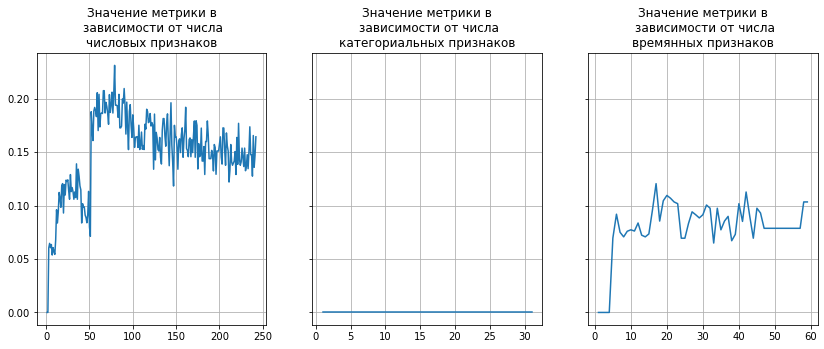

In [153]:
plot_metric_dep_f_count(num_x=range(1, X_sort_num.shape[1] // 4 + 1), 
                        num_y=num_met, 
                        cat_x=range(1, X_sort_cat.shape[1] // 4 + 1), 
                        cat_y=cat_met, 
                        time_x=range(1, X_sort_time.shape[1] + 1), 
                        time_y=time_met)

In [207]:
X = np.concatenate((X_sort_time[:, :20], X_sort_num[:, :79]), axis=1)
X = np.nan_to_num(X)
X

array([[ 0.   ,  1.   ,  0.   , ...,  0.038, -0.03 ,  0.   ],
       [ 0.   ,  1.   ,  0.   , ..., -0.036,  0.   , -0.134],
       [ 0.   ,  1.   ,  0.   , ...,  0.119, -0.077,  0.   ],
       ...,
       [ 0.   ,  1.   ,  0.   , ..., -0.017, -0.003,  0.   ],
       [ 0.   ,  1.   ,  0.   , ...,  0.001,  0.   ,  0.   ],
       [ 0.   ,  1.   ,  1.   , ...,  0.043,  0.   ,  0.   ]])

# Построение модели

Сформулируем задачу машинного обучения. Пусть имеем матрицу объектов-признаков X; каждая строка соответствует своему объекту (объектов всего у нас n), а столбец значению признака для каждого объекта (признаков всего m). Также имеем таргеты для каждого объекта из матрицы X (для каждой строки). 

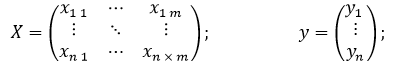

Необходимо найти такую модель a, которая максимально приближает зависимость y: X→Y (где y - искомая зависимость, Y – множество значений y).

Суть алгоритма градиентного бустинга заключается в последовательном построении ансамбля $a_m\left(x\right)$, в котором каждая последующая модель ${\grave{f}}_k(x)$ минимизирует ошибку предыдущих. Величина m – количество моделей, лежащих в данный момент в ансамбле, x – входной вектор признаков объкекта.

$$a_m\left(x\right)=\sum_{k=1}^{m}{{\grave{f}}_k(x)};$$

Обычно за первую модель принимается какое-либо константное значение $\zeta$ - это может быть среднее значение вектора y для задачи регрессии, или наиболее частая метка класса в обучающей выборке для задач классификации.  

$${\grave{f}}_1\left(x\right)=\zeta$$

Далее данная модель помещается в ансамбль $a(x)$.
При построении ансамбля также необходимо выбрать функцию потерь $L\left(y_{i\ },a_s\right)$, по которой можно будет определить, насколько ансамбль ошибается. Наиболее часто применяют квадратичную функцию потерь $MSE(y_{i\ },a_s)$. Это связано с тем, что она непрерывна и является гладкой, что позволяет ее без проблем дифференцировать.

$$L\left(y_{i\ },a_s\right)=MSE(y_{i\ },a_s)={(y_{i\ }-a_s)}^2$$

Сумма ошибок для всех элементов выборки называется эмпирическим риском $\mathcal{L}$.

$$\mathcal{L}(y_\ ,a_s)=\sum_{i=1}^{n}L\left(y_{i\ },a_s\right)$$

Все модели ансамбля (кроме первой) считаются по следующему алгоритму. Пусть ансамбль включает в себя t моделей. 

$$a_t\left(x\right)=\sum_{k=1}^{t}{{\grave{f}}_k(x)}$$

Тогда для построения ${\grave{f}}_{t+1}(x)$ выполним следующие действия:

Вычислим частные производные функции потерь по предсказаниям ансамбля для каждого объекта выборки. Фактически мы строим вектор в пространстве, где каждая ось соответствует своему объекту в обучающей выборке. Полученный вектор умножим на минус 1 для получения антиградиента функции потерь $g$. Так как мы используем $MSE$, то антиградиент будет считаться следующим образом:

$$g=-\left(\begin{matrix}\frac{\partial L\left(y_1,\ a_t\left(x_1\right)\right)}{\partial a_t\left(x_1\right)}\\\vdots\\\frac{\partial L\left(y_n,\ a_t\left(x_n\right)\right)}{\partial a_t\left(x_n\right)}\\\end{matrix}\right)=-\left(\begin{matrix}\frac{\partial MSE\left(y_{1\ },a_t\left(x_1\right)\right)}{\partial a_t\left(x_1\right)}\\\vdots\\\frac{\partial MSE\left(y_{n\ },a_t\left(x_n\right)\right)}{\partial a_t\left(x_n\right)}\\\end{matrix}\right)=\left(\begin{matrix}2(y_1-a_t\left(x_1\right))\\\vdots\\2(y_n-a_t\left(x_n\right))\\\end{matrix}\right)$$

Обучим новую модель $h$ на таргетах, соответствующих значениям $g$. Так как антиградиент указывает на направление уменьшения функции (в нашем случае - ошибки), то новая модель $h $ будет компенсировать ошибку, оставшуюся после обучения предыдущих моделей, повышая точность предсказаний всего ансамбля в целом.  В роли $h$ могут выступать любые алгоритмы классического машинного обучения (линейная регрессия, классификация, решающее дерево). В данной работе в качестве $h$ берется решающее дерево, $θ_(t+1)$ – параметры этой модели (дерева). 

$$\mathcal{L}\left(g,h\right)=\sum_{i=1}^{n}{L\left(g_i,h(x_i,\theta_{t+1})\right);}$$

$${\underset{\theta_{t+1}}{\mathrm{argmin}}}$$

$$\theta_{t+1}={\underset{\theta_{t+1}}{\mathrm{argmin}}}{\mathcal{L}\left(g,h(X,\ \theta_{t+1})\right)}={\underset{\theta_{t+1}}{\mathrm{argmin}}}\sum_{i=1}^{n}L\left(g_i,h(x_i,\theta_{t+1})\right)$$

После подбора всех параметров построенная модель добавляется к исходному ансамблю (веса новой модели не указываются, так как они больше меняться не будут).

$$a_{t+1}\left(x\right)=a_t\left(x\right)+{\grave{f}}_{t+1}\left(x_i\right)$$


Разобьём выборку X на обучающую X_train и контрольную выборку X_test. Контрольная выборка играет ключевую роль, так как в ней содержится информация, которую модель не увидит во время своего обучения. На основе частоты правильных ответов модели при пропускании через нее этих данных делается вывод о ее качестве. Функция (или алгоритм), оценивающая качество работы модели называется метрикой. 

В данной работе будет использоваться корреляция Мэтьюса (MCC) в качестве основной метрики. Где: True positive (TP) – количество ответов модели, где истинная метка равна 1 и совпала с предсказанной; True negative (TN) – число объектов, где истинная метка равна -1 и совпала с предсказанной; False negative (FN) – количество примеров, где истинная метка равна 1 и не совпала с предсказанной. False positive (FP) соответствует ответам модели, при которых истинная метка равна -1 и не совпала с предсказанной.
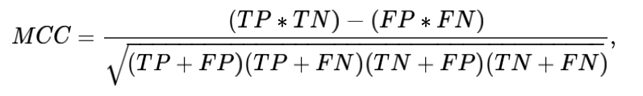
 
Мы также возьмем некоторые побочные метрики, которые могут оказаться полезны: ROC (ROC-AUC); Precision (точность), Recall (полнота); accuracy (точность, в основе которой доля правильных ответов модели). Первые три метрики прекрасно подходят для работы с несбалансированными выборками. Последняя крайне чувствительна к дисбалансу в выборке.

Все вышеперечисленные величины вычисляются в функции show_metrics


In [208]:
X_train = X[:X.shape[0] // 2]
y_train = y[:X.shape[0] // 2]
X_test = X[X.shape[0] // 2:]
y_test = y[X.shape[0] // 2:]
model = XGBClassifier(use_label_encoder=False, tree_method="gpu_hist", objective= 'binary:logistic', learning_rate=0.1, random_seed=234)
model.fit(X_train, y_train)
probas = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
show_metrics(y_test, y_pred)

[03:27:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:576: 
Parameters: { "random_seed" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[03:27:56] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,accuracy,matthews_corrcoef,roc_auc_score,precision,recall,f1_score
0,0.995,0.175,0.522,0.694,0.045,0.084


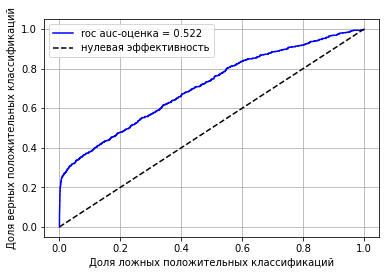

In [209]:
%matplotlib inline
plot_roc(y_true=y_test, y_pred=y_pred, y_pred_proba=probas)

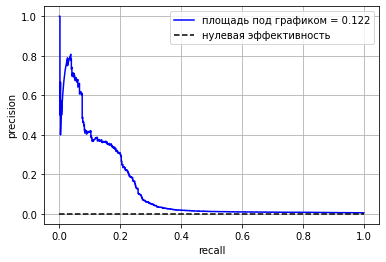

In [210]:
plot_pr_rec_curve(y_true=y_test, y_pred=y_pred, y_pred_proba=probas)

# Подобор гиперпараметров

In [211]:
search_params = dict(
        max_depth=range(2, 10),
        learning_rate=np.arange(0.1, 1, 0.2),
        n_estimators=range(2, 12, 1),
        
    
    )

model = XGBClassifier(use_label_encoder=False, 
                          tree_method="gpu_hist",
                          predictor='gpu_predictor',
                          objective= 'binary:logistic')
'''
split_strategy = model_selection.StratifiedShuffleSplit(n_splits = 10, test_size = 0.3)
for train_indexs, test_indexs in split_strategy.split(X, y):
    X_train = X[train_indexs]
    y_train = y[train_indexs]
    X_test = X[test_indexs]
    y_test = y[test_indexs]
    model = XGBClassifier(use_label_encoder=False, 
                          **search_params,
                          tree_method="gpu_hist",
                          predictor='gpu_predictor',
                          objective= 'binary:logistic', 
                          random_seed=234)
    model.fit(X_train, y_train)
'''
model = fit_and_find_hpar(model=model, 
                          param_dis=search_params,
                          X=X,
                          y=y,
                          n_splits=11, 
                          test_size=0.3
                         )

print(model.best_score_)
print(model.best_params_)

'''
probas = model.predict_proba(X_test)[:, 1]
y_pred = model.predict(X_test)
show_metrics(y_test, y_pred)
'''

[03:28:22] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:28:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:28:23] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[03:28:24] WARNING: C:/Users/Administrator/workspace/xgboost-win64_rel

'\nprobas = model.predict_proba(X_test)[:, 1]\ny_pred = model.predict(X_test)\nshow_metrics(y_test, y_pred)\n'

In [214]:
print('best matthews_corrcoef:', model.best_score_)
print(model.best_params_)

best matthews_corrcoef: 0.19256790655274425
{'n_estimators': 7, 'max_depth': 8, 'learning_rate': 0.5000000000000001}


# Использованные источники
https://www.kaggle.com/c/bosch-production-line-performance/overview

